# Loan Rates Forecast Models Comparison test plan

#### Setup

In [1]:
# Quick hack to load local SDK code

import os

os.chdir(os.path.join(os.getcwd(), "../.."))

# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()

True

In [2]:

import validmind as vm
vm.init(  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "e22b89a6b9c2a27da47cb0a09febc001",
  api_secret = "a61be901b5596e3c528d94231e4a3c504ef0bb803d16815f8dfd6857fac03e57",
  project = "clgmfxwvp0000k8rlc997oe9t")


Connected to ValidMind


In [3]:
# System libraries
import glob

# ML libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from arch.unitroot import PhillipsPerron, DFGLS
import xgboost as xgb
from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Load FRED Data

In [4]:
def merge_fred_csv_files(file_pattern):
    # Use glob to find all files matching the specified pattern
    file_list = glob.glob(file_pattern)

    # Initialize an empty list to store individual DataFrames
    dataframes = []

    # Iterate through each file in the file list
    for file in file_list:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file, parse_dates=['DATE'], index_col='DATE')

        # Add the DataFrame to the list of DataFrames
        dataframes.append(df)

    # Merge all the DataFrames in the list into a single DataFrame
    merged_df = pd.concat(dataframes, axis=1)

    return merged_df


In [5]:
file_pattern = './notebooks/datasets/time_series/raw/fred/*.csv'
df = merge_fred_csv_files(file_pattern)
display(df)

,GDPC1,GS5,GS10,GS3,MORTGAGE30US,UNRATE,CPIAUCSL,FEDFUNDS,GDP
DATE,,,,,,,,,
1947-01-01,2034.450,NaN,NaN,NaN,NaN,NaN,21.48,NaN,243.164
1947-02-01,NaN,NaN,NaN,NaN,NaN,NaN,21.62,NaN,NaN
1947-03-01,NaN,NaN,NaN,NaN,NaN,NaN,22.00,NaN,NaN
1947-04-01,2029.024,NaN,NaN,NaN,NaN,NaN,22.00,NaN,245.968
1947-05-01,NaN,NaN,NaN,NaN,NaN,NaN,21.95,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-04-01,NaN,NaN,3.46,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-06,NaN,NaN,NaN,NaN,6.28,NaN,NaN,NaN,NaN
2023-04-13,NaN,NaN,NaN,NaN,6.27,NaN,NaN,NaN,NaN


Preselection of variables.

In [6]:
selected_cols = ['MORTGAGE30US', 'UNRATE', 'GS10', 'FEDFUNDS'] 
df = df[selected_cols]

Plot time series.

In [7]:
def plot_time_series(df, cols_to_plot=None, title=''):
    """
    Plot multiple time-series in the same axes using seaborn.

    :param df: DataFrame with time-series data
    :param cols_to_plot: List of column names to plot. If None, plot all columns in df.
    :param title: Title of the plot, default is ''
    """
    if cols_to_plot is None:
        cols_to_plot = df.columns.tolist()

    # Create a new DataFrame with the columns to plot
    plot_df = df[cols_to_plot]

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the time-series data
    plt.figure(figsize=(12, 6))
    for col in plot_df.columns:
        sns.lineplot(data=plot_df[col], label=col)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()


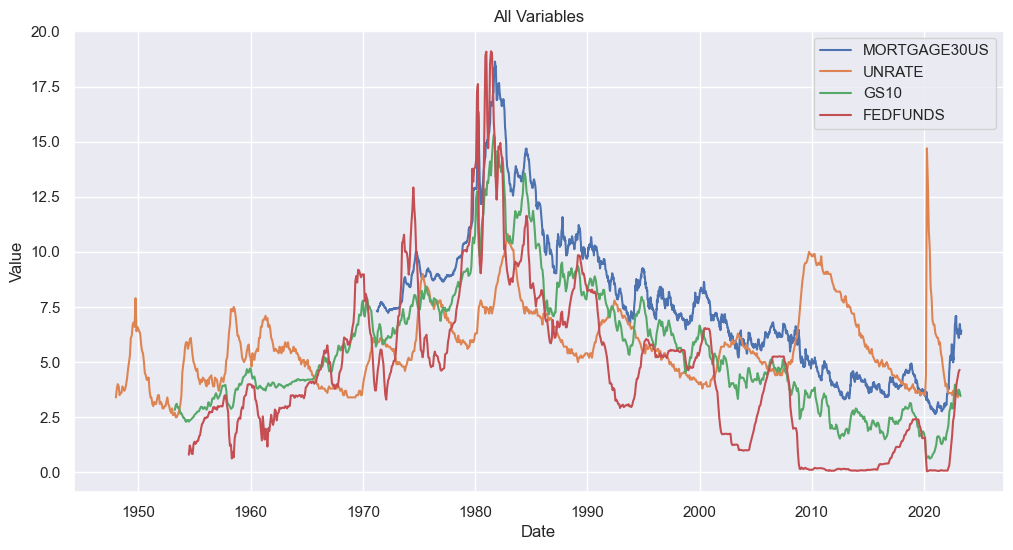

In [8]:
plot_time_series(df, title='All Variables')

### 4.1.2. Data Description

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3551 entries, 1947-01-01 to 2023-04-27
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MORTGAGE30US  2718 non-null   float64
 1   UNRATE        903 non-null    float64
 2   GS10          841 non-null    float64
 3   FEDFUNDS      825 non-null    float64
dtypes: float64(4)
memory usage: 138.7 KB


### 4.1.3. Data Quality

## VM data Quality Test plan

In [10]:
vm_dataset = vm.init_dataset(
    dataset=df,
    target_column="MORTGAGE30US"
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


In [11]:
vm.test_plans.list_plans()

ID,Name,Description
sklearn_classifier_metrics,SKLearnClassifierMetrics,Test plan for sklearn classifier metrics
sklearn_classifier_validation,SKLearnClassifierPerformance,Test plan for sklearn classifier models
sklearn_classifier_model_diagnosis,SKLearnClassifierDiagnosis,Test plan for sklearn classifier model diagnosis tests
sklearn_classifier,SKLearnClassifier,Test plan for sklearn classifier models that includes both metrics and validation tests
tabular_dataset,TabularDataset,Test plan for generic tabular datasets
tabular_dataset_description,TabularDatasetDescription,Test plan to extract metadata and descriptive statistics from a tabular dataset
tabular_data_quality,TabularDataQuality,Test plan for data quality on tabular datasets
normality_test_plan,NormalityTestPlan,Test plan to perform normality tests.
autocorrelation_test_plan,AutocorrelationTestPlan,Test plan to perform autocorrelation tests.
seasonality_test_plan,SesonalityTestPlan,Test plan to perform seasonality tests.


In [12]:
vm.test_plans.describe_plan("time_series_data_quality")

Attribute,Value
ID,time_series_data_quality
Name,TimeSeriesDataQuality
Description,Test plan for data quality on time series datasets
Required Context,['dataset']
Tests,"TimeSeriesOutliers (ThresholdTest), TimeSeriesMissingValues (ThresholdTest), TimeSeriesFrequency (ThresholdTest)"
Test Plans,[]



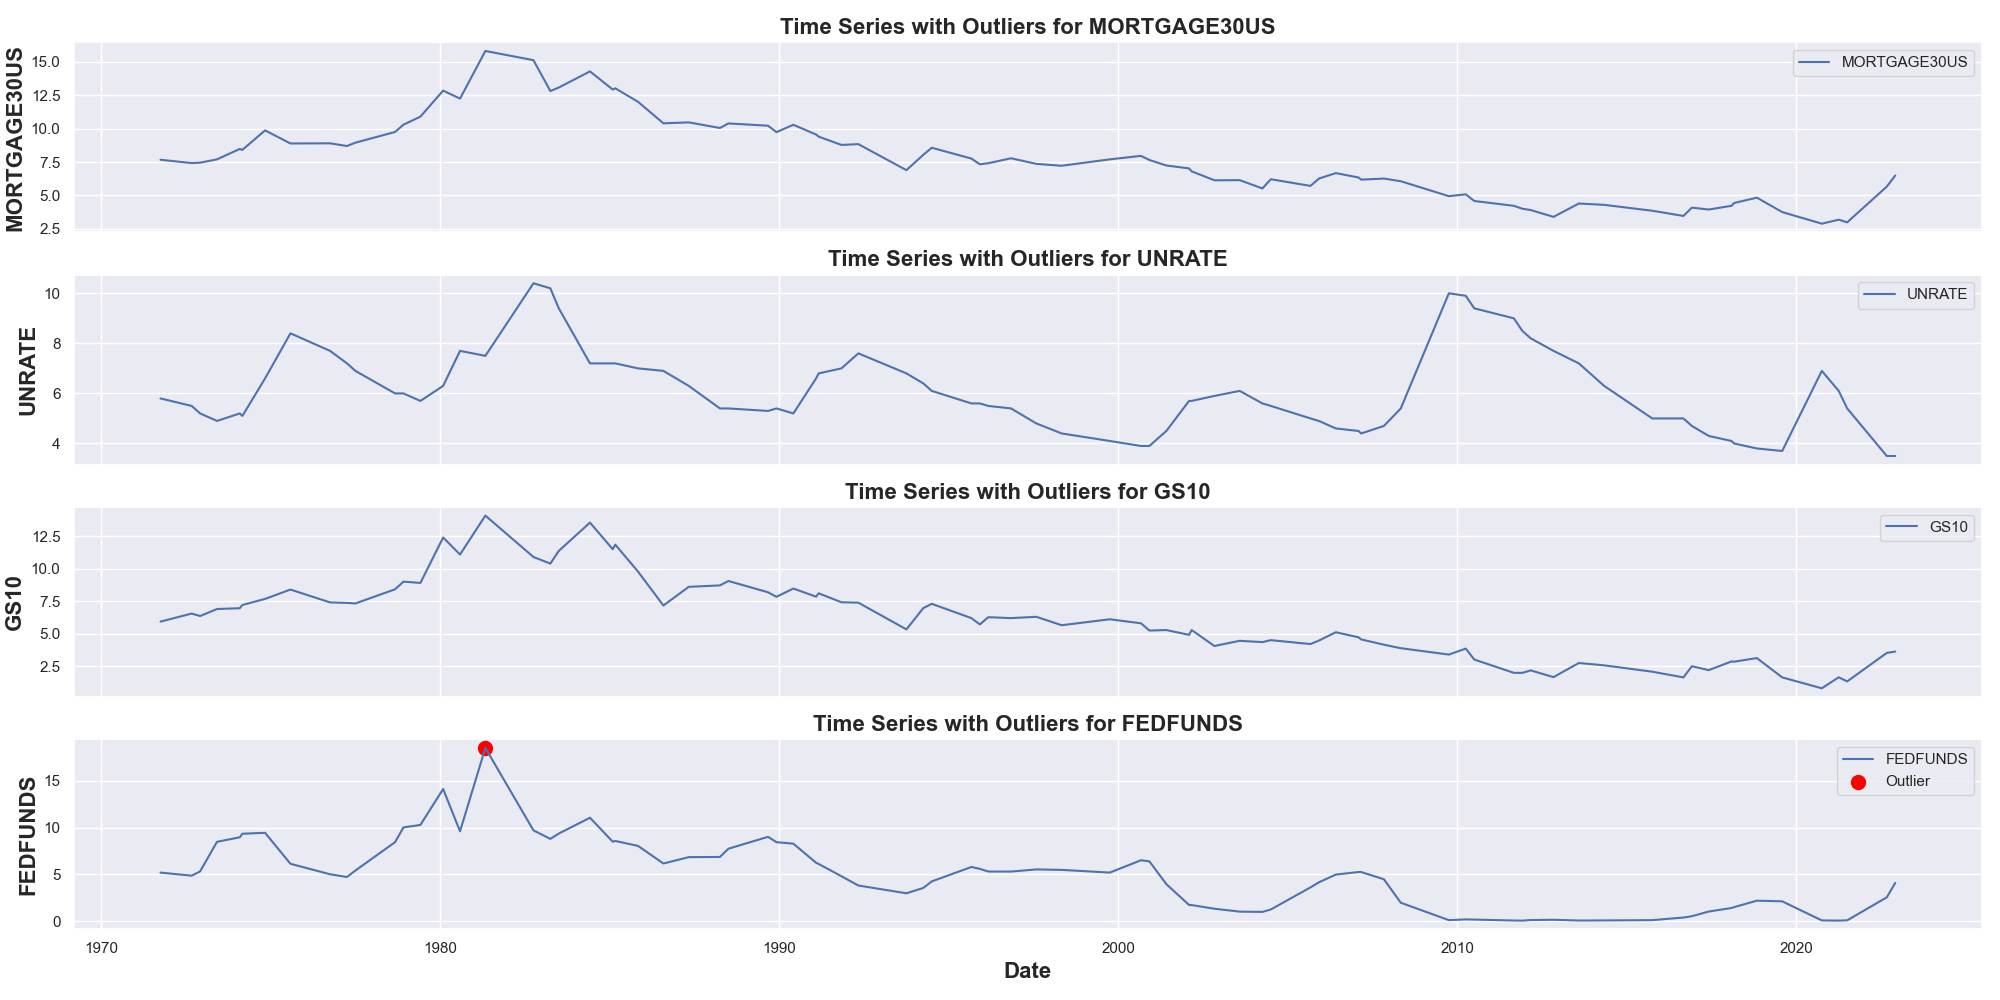
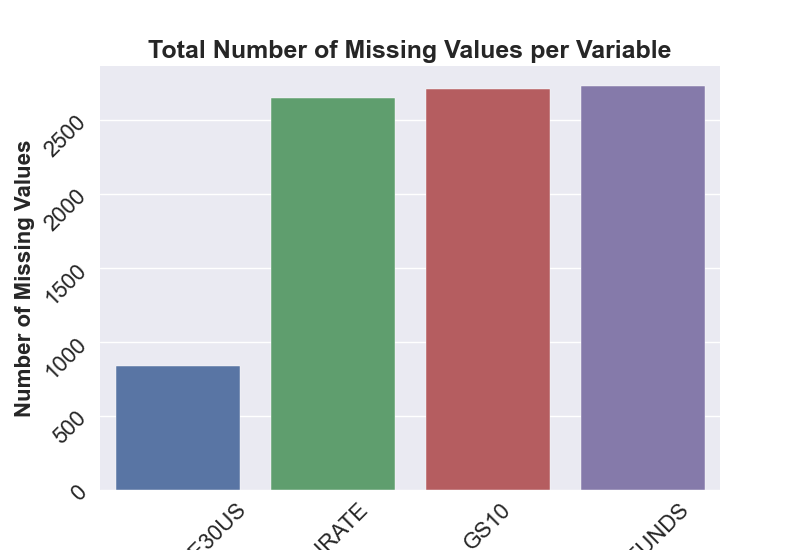
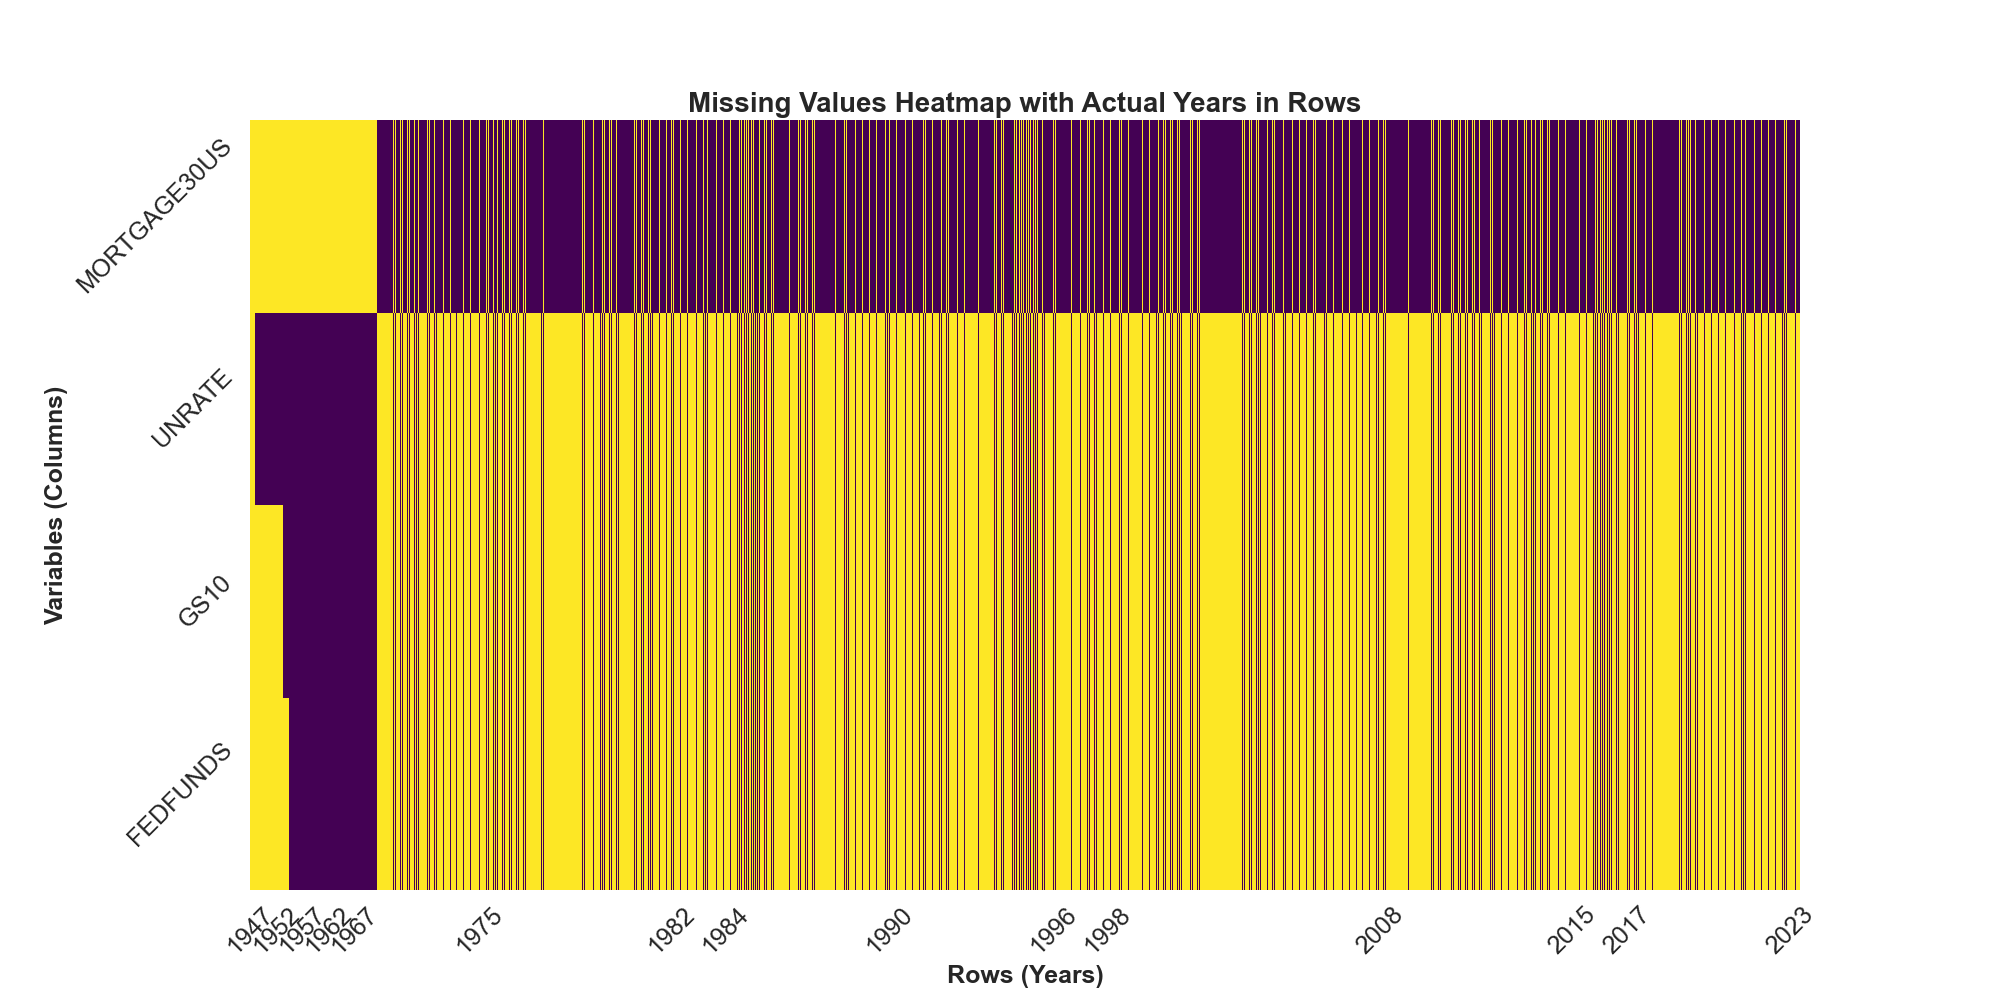
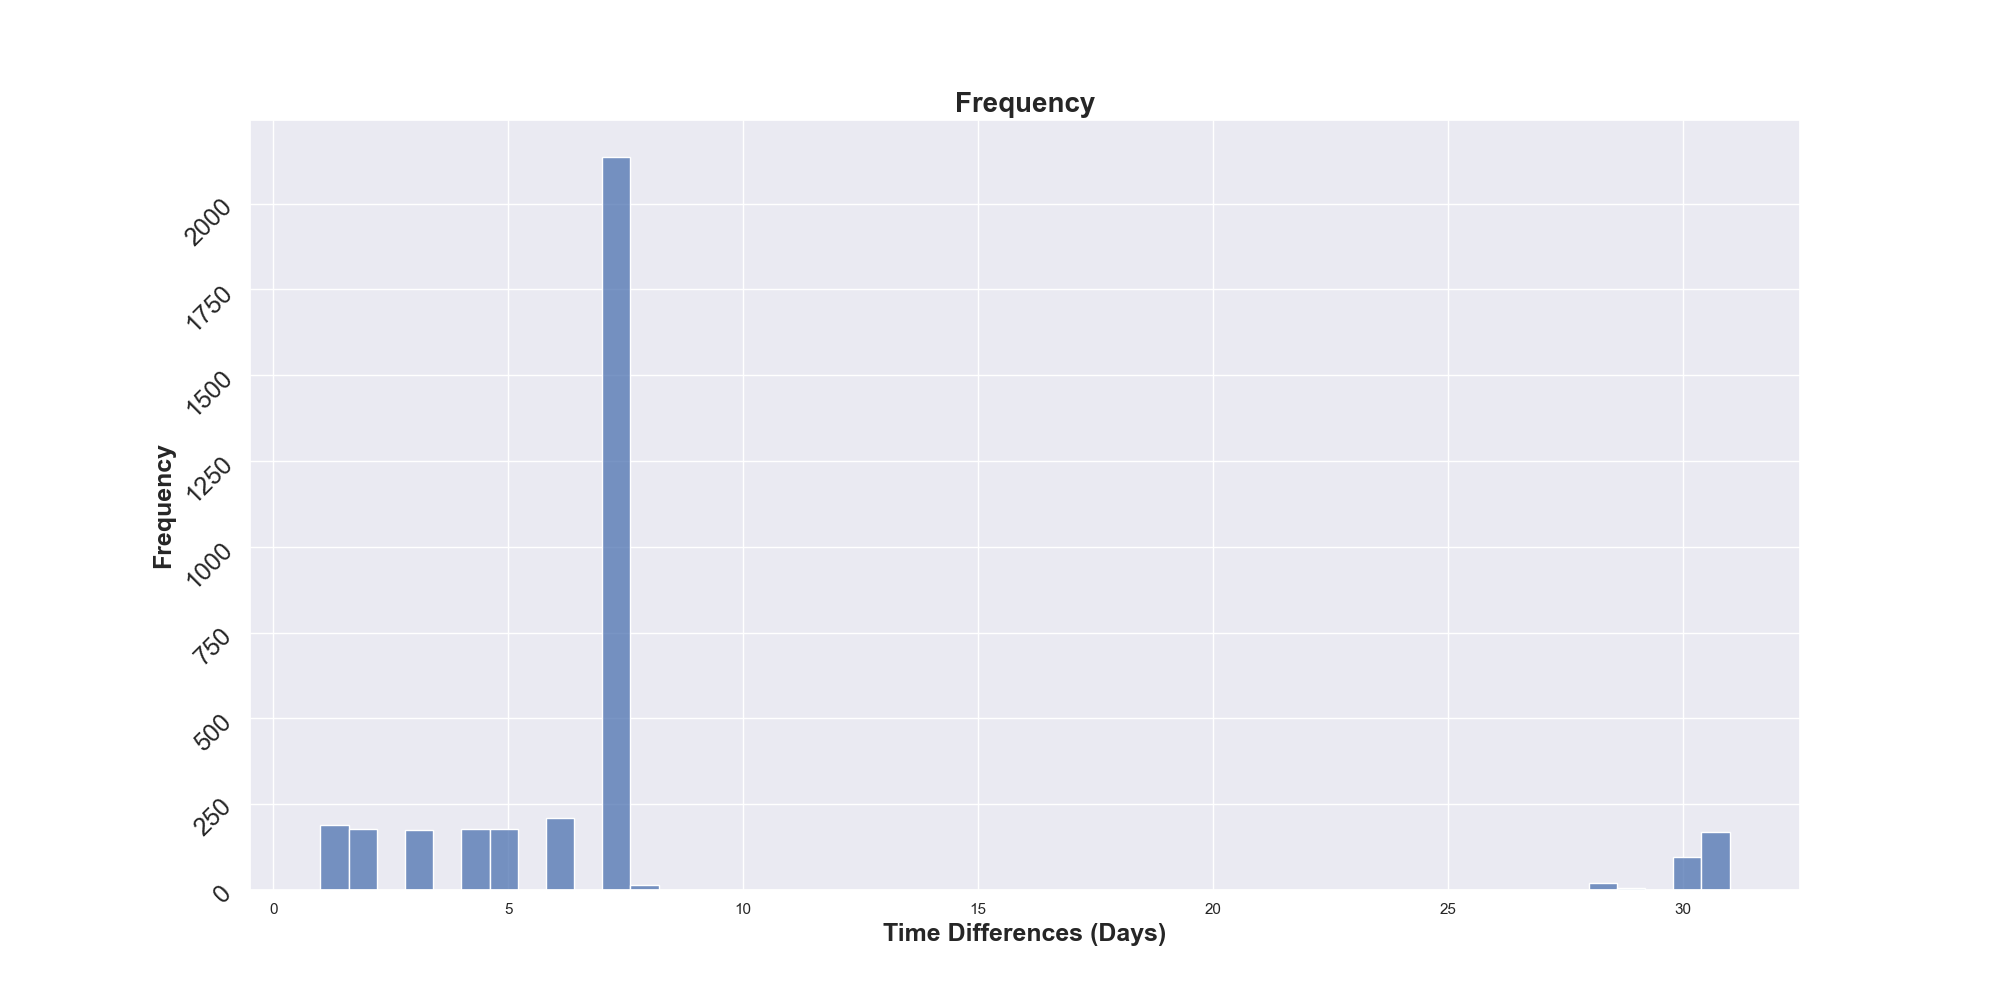

In [13]:
config={
    "time_series_outliers": {
        "zscore_threshold": 3.5,

    },
    "time_series_missing_values":{
        "min_threshold": 2,
    }
}

plan = vm.run_test_plan("time_series_data_quality", dataset=vm_dataset, config=config)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...



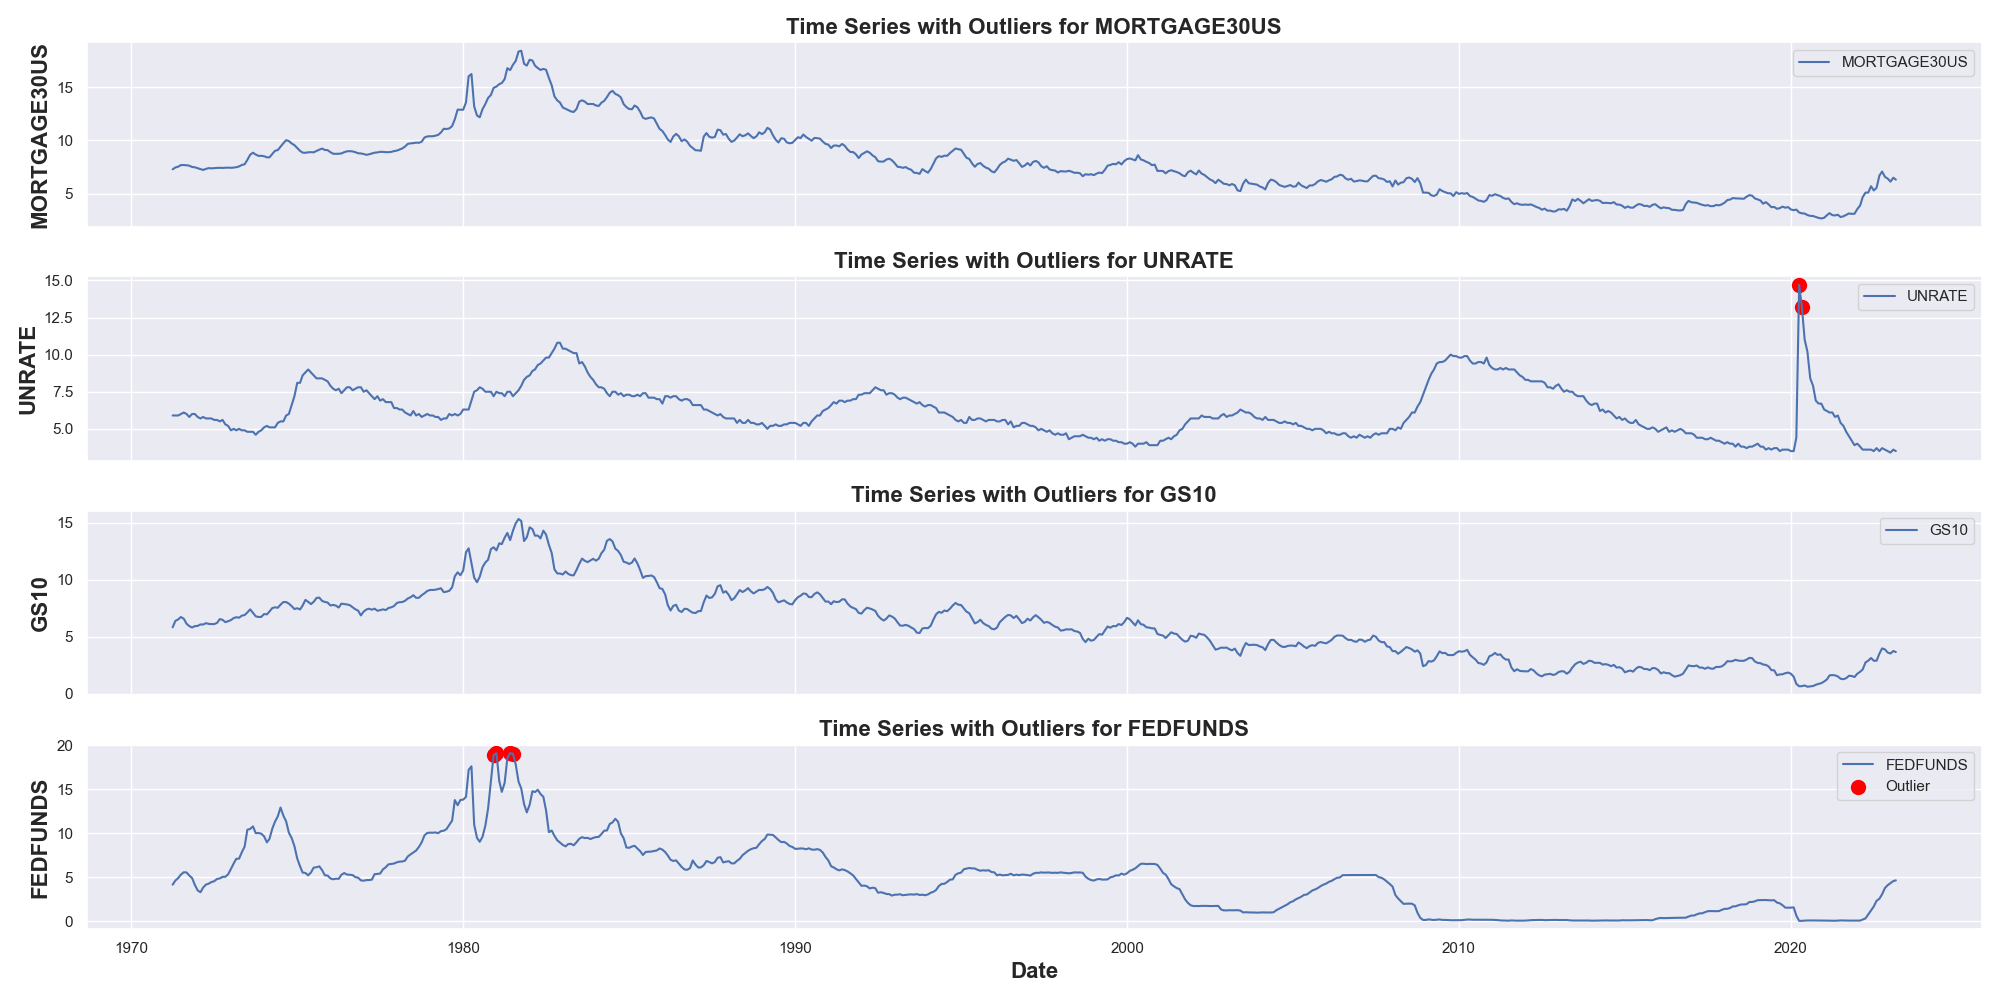
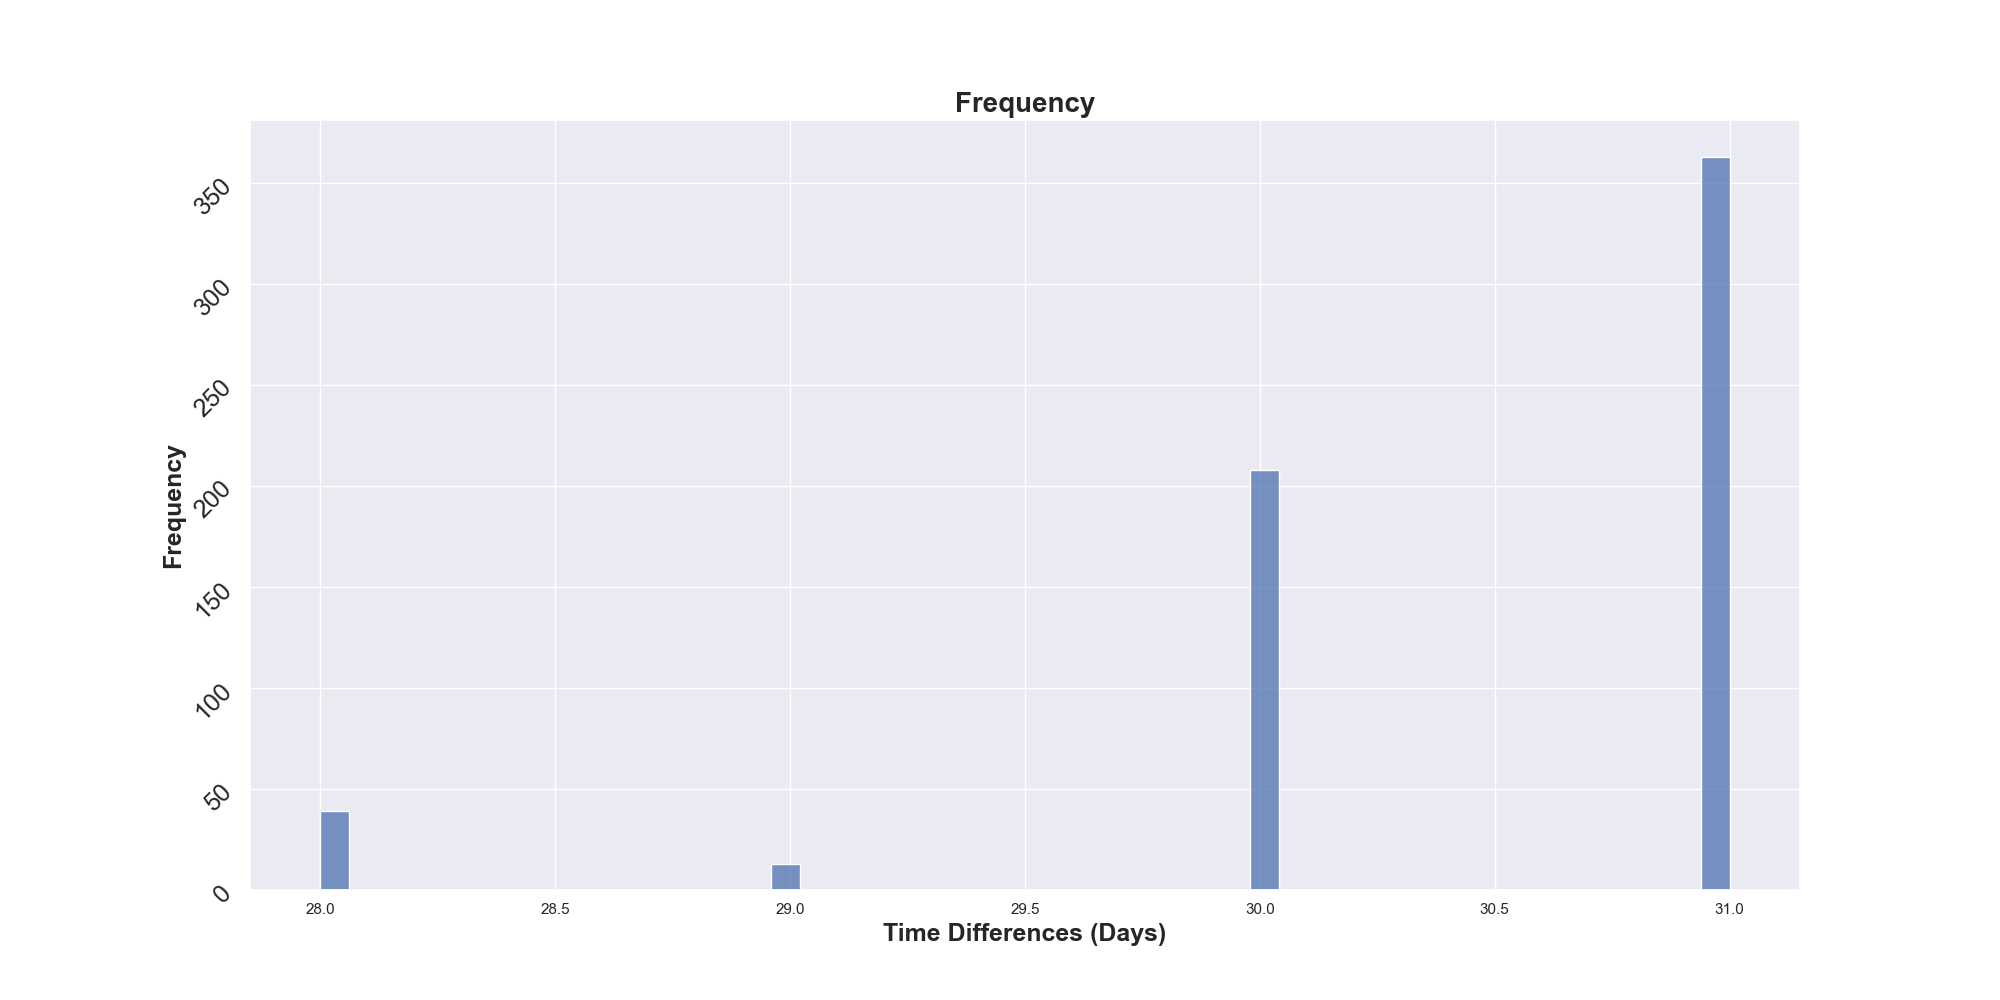

In [14]:
df = df.resample('MS').last()
df = df.dropna()
vm_dataset = vm.init_dataset(
    dataset=df,
    target_column="MORTGAGE30US"
)
config={
    "time_series_outliers": {
        "zscore_threshold": 3.5,

    },
    "time_series_missing_values":{
        "min_threshold": 2,
    }
}

plan = vm.run_test_plan("time_series_data_quality", dataset=vm_dataset, config=config)

## 4.2. Exploratory Data Analysis

In [15]:
df_diff = df.diff().dropna()

## 4.3. Model Methodology

## 4.4. Training Data

### 4.4.1. Sampling 

**Step 1: Split dataset into Training and Test**

In [16]:
split_index = int(len(df) * 0.8)   # use 80% of the data for training
df_train, df_test = df[:split_index], df[split_index:]

**Step 2: Create a Stationary Train and Test Dataset**

In [17]:
# Apply first difference to both training and test df
df_train_diff = df_train.diff().dropna()
df_test_diff = df_test.diff().dropna()


## 4.5. Model Training

### Model 1: Loan Rates and FEDFUNDS

**Step 1: Fit Model**

In [18]:
# Add the independent variables with no intercept
X = df_train_diff['FEDFUNDS']

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_1 = sm.OLS(y, X).fit()

# Display the model summary
print(model_1.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.286
Model:                            OLS   Adj. R-squared (uncentered):              0.284
Method:                 Least Squares   F-statistic:                              198.8
Date:                Wed, 10 May 2023   Prob (F-statistic):                    3.22e-38
Time:                        16:48:32   Log-Likelihood:                         -57.220
No. Observations:                 498   AIC:                                      116.4
Df Residuals:                     497   BIC:                                      120.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Model 2: Loan Rates, constant and FEDFUNDS

**Step 1: Fit Model**

In [19]:
# Add a constant to the independent variables for the linear regression model
X = sm.add_constant(df_train_diff['FEDFUNDS'])

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_2 = sm.OLS(y, X).fit()

# Display the model summary
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:           MORTGAGE30US   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     198.3
Date:                Wed, 10 May 2023   Prob (F-statistic):           3.99e-38
Time:                        16:48:32   Log-Likelihood:                -57.120
No. Observations:                 498   AIC:                             118.2
Df Residuals:                     496   BIC:                             126.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0055      0.012     -0.448      0.6

**Step 2: Reasoning**

### Model 3: Loan Rates and GS10

In [20]:
# Add a constant to the independent variables for the linear regression model
X = df_train_diff['GS10']

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_3 = sm.OLS(y, X).fit()

# Display the model summary
print(model_3.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.529
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              558.1
Date:                Wed, 10 May 2023   Prob (F-statistic):                    2.80e-83
Time:                        16:48:32   Log-Likelihood:                          46.439
No. Observations:                 498   AIC:                                     -90.88
Df Residuals:                     497   BIC:                                     -86.67
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Model 4: Loan Rates, FEDFUNDS and GS10

**Step 1: Fit Model**

In [21]:
# Add a constant to the independent variables for the linear regression model
X = df_train_diff[['GS10', 'FEDFUNDS']]

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_4 = sm.OLS(y, X).fit()

# Display the model summary
print(model_4.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.621
Model:                            OLS   Adj. R-squared (uncentered):              0.620
Method:                 Least Squares   F-statistic:                              407.0
Date:                Wed, 10 May 2023   Prob (F-statistic):                   2.45e-105
Time:                        16:48:32   Log-Likelihood:                          100.84
No. Observations:                 498   AIC:                                     -197.7
Df Residuals:                     496   BIC:                                     -189.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Step 2: Reasoning**

### Model 5: Loan Rates, FEDFUNDS, GS10 and UNRATE

**Step 1: Fit Model**

In [22]:
# Add a constant to the independent variables for the linear regression model
X = df_train_diff[['GS10', 'FEDFUNDS', 'UNRATE']]

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_5 = sm.OLS(y, X).fit()

# Display the model summary
print(model_5.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.622
Model:                            OLS   Adj. R-squared (uncentered):              0.619
Method:                 Least Squares   F-statistic:                              271.0
Date:                Wed, 10 May 2023   Prob (F-statistic):                   4.91e-104
Time:                        16:48:32   Log-Likelihood:                          100.97
No. Observations:                 498   AIC:                                     -195.9
Df Residuals:                     495   BIC:                                     -183.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## VM model summary test plan

In [23]:
vm_model = vm.init_model(model_1)
vm_train_ds = vm.init_dataset(dataset=df_train_diff, type="generic", target_column="MORTGAGE30US")
vm_test_ds = vm.init_dataset(dataset=df_test_diff, type="generic", target_column="MORTGAGE30US")


Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


In [24]:
vm.test_plans.list_plans()

ID,Name,Description
sklearn_classifier_metrics,SKLearnClassifierMetrics,Test plan for sklearn classifier metrics
sklearn_classifier_validation,SKLearnClassifierPerformance,Test plan for sklearn classifier models
sklearn_classifier_model_diagnosis,SKLearnClassifierDiagnosis,Test plan for sklearn classifier model diagnosis tests
sklearn_classifier,SKLearnClassifier,Test plan for sklearn classifier models that includes both metrics and validation tests
tabular_dataset,TabularDataset,Test plan for generic tabular datasets
tabular_dataset_description,TabularDatasetDescription,Test plan to extract metadata and descriptive statistics from a tabular dataset
tabular_data_quality,TabularDataQuality,Test plan for data quality on tabular datasets
normality_test_plan,NormalityTestPlan,Test plan to perform normality tests.
autocorrelation_test_plan,AutocorrelationTestPlan,Test plan to perform autocorrelation tests.
seasonality_test_plan,SesonalityTestPlan,Test plan to perform seasonality tests.


#### Model perfomance Test

In [25]:
from validmind.model_validation.statsmodels.metrics import RegressionModelSummary
from validmind.vm_models.test_context import TestContext
test_context = TestContext(model=vm_model)
metric = RegressionModelSummary(test_context=test_context)
metric.run()
metric.result.metric.value


{'Independent Variables': ['FEDFUNDS'],
 'R-Squared': 0.2857335514089734,
 'Adjusted R-Squared': 0.2842963955767983,
 'MSE': 0.0738243956495036,
 'RMSE': 0.27170645124748805}

In [26]:
# from validmind.model_validation.statsmodels.metrics import RegressionModelOutsampleComparison
# from validmind.vm_models.test_context import TestContext
# test_context = TestContext(model=vm_model)
# metric = RegressionModelOutsampleComparison(test_context=test_context)
# metric.run()
# metric.result.metric.value

In [27]:
vm_model_1 = vm.init_model(model_1)

model_performance_test_plan = vm.run_test_plan("regression_model_performance", 
                                             model=vm_model_1
                                            )


Failed to log result: TestPlanMetricResult(result_id="regression_model_summary", metric, figures) for test plan result 'TestPlanMetricResult(result_id="regression_model_summary", metric, figures)':   0%|          | 0/1 [00:00<?, ?it/s]

Could not log metrics to ValidMind API
{"code":"IntenalError","message":"Internal server error"}



Exception: {"code":"IntenalError","message":"Internal server error"}


In [ ]:
vm_model_1 = vm.init_model(model_1)
vm_model_2 = vm.init_model(model_2)
vm_model_3 = vm.init_model(model_3)

vm_test_ds = vm.init_dataset(dataset=df_test_diff, type="generic", target_column="MORTGAGE30US")
print(vm_test_ds.fields)
model_comparison_test_plan = vm.run_test_plan("regression_models_comparison", 
                                             models=[vm_model_1, vm_model_2, vm_model_3],
                                             test_ds=vm_test_ds,
                                            )

                                            

In [ ]:
def get_feature_names(model):
    """
    Returns a list of feature names used by a scikit-learn or statsmodels model object.

    Parameters:
        model (sklearn estimator or statsmodels model): A trained scikit-learn or statsmodels model object with a `coef_` attribute.

    Returns:
        feature_names (list): A list of feature names used by the model.
    """

    # Check if the model is a scikit-learn model with a `coef_` attribute (for linear models)
    if hasattr(model, 'coef_'):
        # Retrieve the feature names from the model's input data
        feature_names = model.coef_.shape[1]
        if hasattr(model, 'named_steps'):
            if hasattr(model.named_steps['preprocessor'], 'get_feature_names'):
                feature_names = model.named_steps['preprocessor'].get_feature_names()
    
    # Check if the model is a statsmodels model with a `params` attribute (for linear models)
    elif hasattr(model, 'params'):
        # Retrieve the feature names from the model's input data
        feature_names = model.params.index.tolist()
    
    # Check if the model has a `feature_importances_` attribute (for tree-based models)
    elif hasattr(model, 'feature_importances_'):
        # Retrieve the feature names from the model's input data
        n_features = model.feature_importances_.shape[0]
        feature_names = [f'Feature {i}' for i in range(n_features)]
    
    # If the model doesn't have either attribute, return an error message
    else:
        raise ValueError('Model does not have a `coef_`, `params`, or `feature_importances_` attribute.')

    return feature_names


In [ ]:
get_feature_names(model_2)

In [ ]:
print(vm_test_ds.df.columns)
